In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import pathlib

In [3]:
python_path = pathlib.Path('.').absolute().parent/'python'
os.sys.path.insert(1, str(python_path))

In [9]:
import pinocchio as pin
from robot_properties_kuka.config import IiwaConfig

import meshcat
import meshcat.transformations as tf
import meshcat.geometry as g

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import trange

In [5]:
from vocam.qpnet import DataUtils, QPNet
import vocam.qpnet

In [6]:
import wandb
wandb.init(project="my-test-project", entity="hjzhu")

wandb: Currently logged in as: hjzhu. Use `wandb login --relogin` to force relogin


In [7]:
robot = IiwaConfig.buildRobotWrapper()
model, data = robot.model, robot.data
f_id = model.getFrameId("EE")

In [10]:
wandb.config.nq = model.nq
wandb.config.nv = model.nv
wandb.config.q0 = [np.pi/16.0, -np.pi/16.0, 0, 0, 0, 0, 0]
wandb.config.x_init = np.concatenate([wandb.config.q0, pin.utils.zero(model.nv)])

wandb.config.n_col = 5
wandb.config.u_max = [2.5, 2.5, 2.5, 1.5, 1.5, 1.5, 1.0]
wandb.config.dt = 0.05

wandb.config.isvec = True
wandb.config.n_vars = 3*model.nq*wandb.config.n_col + 2*model.nq

wandb.config.lr_nn = 1e-3
wandb.config.batch_size = 64
wandb.config.epochs = 100

In [11]:
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [12]:
du = DataUtils(robot, wandb.config, viz)
du.load("../data/data_train.pt")

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = QPNet(du.x_train.shape[1], du.y_train.shape[1]).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=wandb.config.lr_nn)
criterion = torch.nn.L1Loss()
train_dataloader = DataLoader(du.data_train, batch_size=wandb.config.batch_size, 
                              shuffle=True)
wandb.watch(network)

[]

In [24]:
x_train, y_train = dg.x_train, dg.y_train
buffer_size = wandb.config.buffer_size
nq = wandb.config.nq
# visualize the init configuration and the desired location for a random data point
k = np.random.randint(buffer_size)
k = 833
x_in = x_train[k].clone().detach()
y = y_train[k].clone().detach()

q_init = x_in[:nq].numpy()
x_des = x_in[-3:]

print(k)
print(x_des)

viz.viewer["box"].set_object(g.Sphere(0.05), 
                         g.MeshLambertMaterial(
                             color=0xff22dd,
                             reflectivity=0.8))
viz.viewer["box"].set_transform(tf.translation_matrix(x_des[-3:].detach().numpy()))
viz.display(q_init)

833
tensor([0.5189, 0.4423, 0.1269])


In [198]:
ddq = []
for j in range(50):
    ioc = IOC(n_col, nq, u_max, dt, eps = 1.0, isvec=isvec)
    optimizer = torch.optim.Adam(ioc.parameters(), lr=lr_qp)
    pred = net(x_in[None,:]).squeeze()
    
    if not isvec:
        ioc.weight = torch.nn.Parameter(torch.reshape(pred[0:n_vars**2], (n_vars, n_vars)))
        ioc.x_nom = torch.nn.Parameter(pred[n_vars**2:])
    else:
        ioc.weight = torch.nn.Parameter(pred[0:n_vars])
        ioc.x_nom = torch.nn.Parameter(pred[n_vars:])

#         print(torch.relu(ioc.weight)*ioc.x_nom)
#         print("--------------------------------------------------")
    x_pred = ioc((x_in[:-3]).detach().numpy()) 
    x_pred = x_pred.detach().numpy()
    ddq.append(x_pred[2*nq:3*nq])

    for i in range(n_col+1):
        q = x_pred[3*nq*i:3*nq*i + nq]
        dq = x_pred[3*nq*i + nq:3*nq*i + 2*nq]

        pin.forwardKinematics(model, data, q, dq, np.zeros(nv))
        pin.updateFramePlacements(model, data)

        viz.display(q)
        time.sleep(0.05)
    
    x_in[0:2*nq] = torch.tensor(x_pred[-2*nq:])
#     print(x_pred[-nq:])

In [200]:
ddq = np.vstack(ddq)

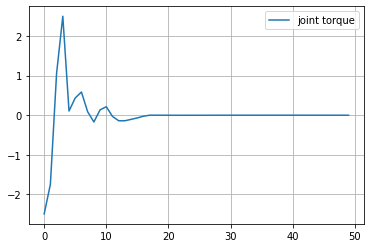

In [206]:
from matplotlib import pyplot as plt

plt.plot(ddq[:, 0], label = "joint torque")
plt.legend()
plt.grid()

In [ ]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,0], label = "x_pos")
plt.grid()
plt.legend()

In [ ]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,1], label = "y_pos")
plt.grid()
plt.legend()

In [ ]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,2], label = "z_pos")
plt.grid()
plt.legend()

In [ ]:
from mim_data_utils import DataLogger, DataReader
reader = DataReader('test.mds')

for i in range(len(reader.data['joint_positions'])):
    q = reader.data['joint_positions'][i]
    viz.display(q)
#     time.sleep(0.05)

In [ ]:
x_train[0]